In [1]:
import os
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as ex
import seaborn as sns
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm

from desdeo_tools.utilities.fast_non_dominated_sorting import non_dominated

from functools import partial

In [2]:
def plotly_animate(reference_data, found_solutions, colormap):
    methods = [
        "DSS",
        "DSS Pruned",
        "Random",
        "Random Pruned",
    ]
    reference_data["method"] = "reference"
    for method in methods:
        found_solutions[method]["method"] = method

    num_rows = found_solutions[methods[0]].shape[0]
    num_frames = 5

    tall_data = pd.DataFrame()
    for i in range(num_frames):
        end_idx = (i + 1) * num_rows // num_frames
        temp_data = reference_data
        temp_data["iteration"] = end_idx
        tall_data = pd.concat([tall_data, temp_data])

    num_rows = 500
    for method, df in found_solutions.items():
        for i in range(num_frames):
            end_idx = (i + 1) * num_rows // num_frames
            end_idx = min(end_idx, df.shape[0])
            temp_data = df.iloc[:end_idx]
            temp_data["iteration"] = (i + 1) * 100
            tall_data = pd.concat([tall_data, temp_data])

    fig = ex.scatter_3d(
        tall_data,
        x="f1",
        y="f2",
        z="f3",
        color="method",
        color_discrete_map=colormap,
        animation_frame="iteration",
        range_x=[0, 1],
        range_y=[0, 1],
        range_z=[0, 1],
    )

    # make marker line width 0
    for i, trace in enumerate(fig.data):
        trace.marker.line.width = 0
        # set opacity to 1
        trace.opacity = 1
        trace.marker.size = 10
        # set opacity of reference points to 0.5
        if trace.name == "reference":
            trace.opacity = 0.3
            trace.marker.size = 5
    return fig

In [3]:
class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
    uniformity: list[float | None] = Field("Uniformity Level of the found solutions at each iteration")
    coverage: list[float] = Field("Coverage Error of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")
    found_solutions: list[list[float]] = Field(description="Found solutions at each iteration")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")

In [4]:
def get_data(problem_name):
    data = pd.read_csv(f"../data/{problem_name}")
    ideal = np.zeros(data.shape[1])
    nadir = np.ones(data.shape[1])
    return data.to_numpy(), ideal, nadir, data.shape[1]


problems = {
    "dtlz5_3": partial(get_data, "dtlz5_3.csv"),
    "dtlz5_4": partial(get_data, "dtlz5_4.csv"),
    "dtlz5_5": partial(get_data, "dtlz5_5.csv"),
    "dtlz7": partial(get_data, "dtlz7.csv"),
    "forest1": partial(get_data, "forest_Carb.csv"),
    "forest2": partial(get_data, "forest_DW.csv"),
    "forest3": partial(get_data, "forest_HA.csv"),
    "forest4": partial(get_data, "forest_Rev.csv"),
    "nforest1": partial(get_data, "nforest_Carb.csv"),
    "nforest2": partial(get_data, "nforest_DW.csv"),
    "nforest3": partial(get_data, "nforest_HA.csv"),
    "forest": partial(get_data, "forest.csv"),
    "nforest": partial(get_data, "nforest.csv"),
    "RE31": partial(get_data, "RE31.csv"),
    "RE32": partial(get_data, "RE32.csv"),
    "RE33": partial(get_data, "RE33.csv"),
    "RE34": partial(get_data, "RE34.csv"),
    "RE35": partial(get_data, "RE35.csv"),
    "RE36": partial(get_data, "RE36.csv"),
    "RE37": partial(get_data, "RE37.csv"),
    "RE41": partial(get_data, "RE41.csv"),
    "RE42": partial(get_data, "RE42.csv"),
    "RE61": partial(get_data, "RE61.csv"),
}

In [33]:
problem = "RE37"

reference_data = problems[problem]()[0]
reference_data = pd.DataFrame(reference_data, columns=[f"f{i+1}" for i in range(reference_data.shape[1])])





root = "../results/"
# list all files in the directory



files = os.listdir(root)
files = [f for f in files if problem in f]

# read all the files
f_results = []
for f in files:
    with open(root + f, "r") as file:
        data = file.read()
        temp = OneExperimentResults.model_validate_json(data)
        if temp.problemName == problem:
            f_results.append(temp)



found_solutions = {}

for r in f_results:
    if r.runID == 1:
        found_solutions[r.method] = pd.DataFrame(
            r.found_solutions,
            columns=[f"f{i+1}" for i in range(len(r.found_solutions[0]))],
        )


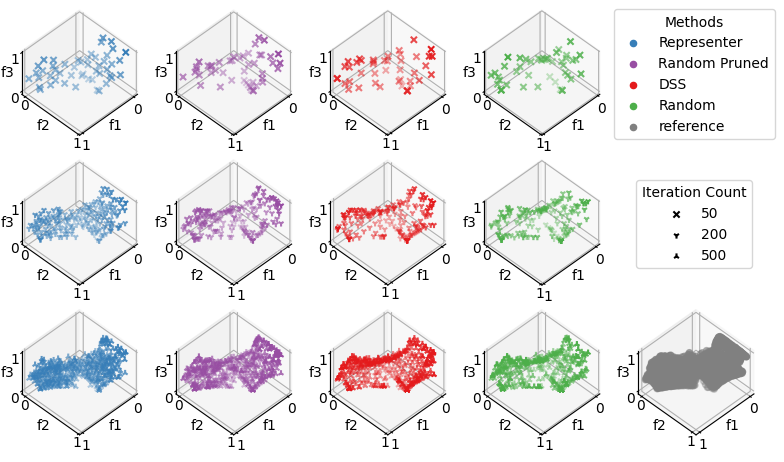

In [34]:
# Create 3d matplotlib plot with a 3 subplot for each method

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#plt.style.use("./plot.mplstyle")

pt = 1./72.27
height = 347.1235 * pt # in inches

fig, axs = plt.subplots(3, 5, figsize=(height * 5 / 3, height), squeeze=False, subplot_kw=dict(projection='3d'))

colormap = {
    "DSS Pruned": "#377eb8",
    "Random Pruned": "#984ea3",
    "DSS": "#e41a1c",
    "Random": "#4daf4a",
    "reference": "gray",
}

method_index = {
    "DSS Pruned": 0,
    "Random Pruned": 1,
    "DSS": 2,
    "Random": 3,
}

iteration_index = {
    50: 0,
    200: 1,
    500: 2,
}

iteration_shapes = {
    50: "x",
    200: "1",
    500: "2",
}

for method, df in found_solutions.items():
    # cols for 50, 200 and 500 iterations
    # rows for 4 methods

    for iteration in [50, 200, 500]:
        ax = axs[iteration_index[iteration], method_index[method]]
        ax.scatter(
            df.iloc[:iteration, 0],
            df.iloc[:iteration, 1], 
            df.iloc[:iteration, 2], 
            c=colormap[method], marker=iteration_shapes[iteration])
        # Add axis labels
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
        ax.set_zlabel("f3")
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_zticks([0, 1])
        # view from the main diagonal
        ax.view_init(elev=45, azim=45)
        ax.xaxis.labelpad = -15
        ax.yaxis.labelpad = -15
        ax.zaxis.labelpad = -15
        ax.xaxis.set_tick_params(pad=-5)
        ax.yaxis.set_tick_params(pad=-7)
        ax.zaxis.set_tick_params(pad=-5)
        # orthogonal projection
        ax.set_proj_type('ortho')
        #ax.set_title(f"{method} - {iteration} iterations")

# Add reference points
ax = axs[2, 4]
ax.scatter(reference_data.iloc[:, 0], reference_data.iloc[:, 1], reference_data.iloc[:, 2], c="gray")
ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_zlabel("f3")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_zticks([0, 1])
ax.view_init(elev=45, azim=45)
ax.xaxis.labelpad = -15
ax.yaxis.labelpad = -15
ax.zaxis.labelpad = -15
ax.xaxis.set_tick_params(pad=-5)
ax.yaxis.set_tick_params(pad=-7)
ax.zaxis.set_tick_params(pad=-5)
# orthogonal projection
ax.set_proj_type('ortho')

# Add legend in the 14th and 15th subplot space
ax = axs[0, 4]
ax.axis("off")
for method, color in colormap.items():
    if method == "DSS Pruned":
        method = "Representer"
    ax.scatter([], [], color=color, label=method)
# legend with custom position and title


ax.legend(loc="center", title="Methods")

# Add iteration labels
ax = axs[1, 4]
ax.axis("off")
for iteration, marker in iteration_shapes.items():
    ax.scatter([], [], marker=marker, label=iteration, color="black")
ax.legend(loc="center", title="Iteration Count")


plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig(f"../figures/{problem}_3d.pdf", bbox_inches="tight")
plt.show()
# save the plot

In [20]:
all_figs_opts = []
for problem, data_reader in problems.items():
    all_figs_opts.append((problem, data_reader))

In [21]:
results = []
with Pool(len(os.sched_getaffinity(0))) as p:
    max_exp = len(all_figs_opts)
    with tqdm(total=max_exp) as pbar:
        for i, result in enumerate(p.imap_unordered(auto_plot, all_figs_opts)):
            pbar.update()

  0%|          | 0/23 [00:00<?, ?it/s]

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [24]:
methods = ["DSS_scipy", "random_selection", "total_random"]
RSE_results = pd.DataFrame(columns=["method", "problem", "RSE"])

for result in results.results:
    method = result.method
    problem = result.problemName
    RSE = result.RSE[-1]
    RSE_results = pd.concat([RSE_results, pd.DataFrame({"method": method, "problem": problem, "RSE": RSE}, index=[0])])

<Axes: xlabel='problem', ylabel='RSE'>

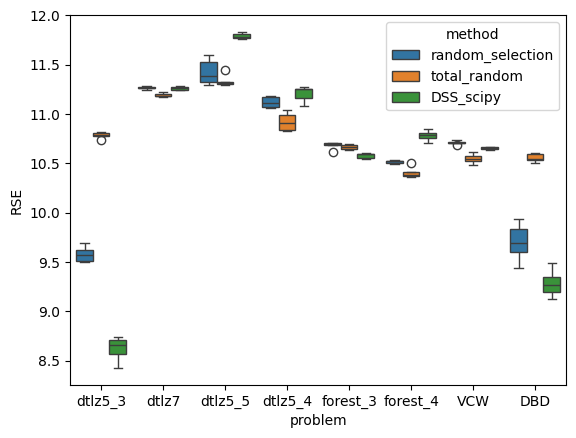

In [25]:
sns.boxplot(data=RSE_results, x="problem", y="RSE", hue="method")

In [30]:
RSE_results.groupby(["problem"], group_keys=True)["RSE"].apply(lambda x: x - x.min()).reset_index()

,problem,level_1,RSE
0,DBD,0,0.812278
1,DBD,0,0.702254
2,DBD,0,0.563676
3,DBD,0,0.309826
4,DBD,0,0.474329
...,...,...,...
115,forest_4,0,0.492310
116,forest_4,0,0.351344
117,forest_4,0,0.397440
118,forest_4,0,0.430423


<Axes: xlabel='iteration', ylabel='1-HV'>

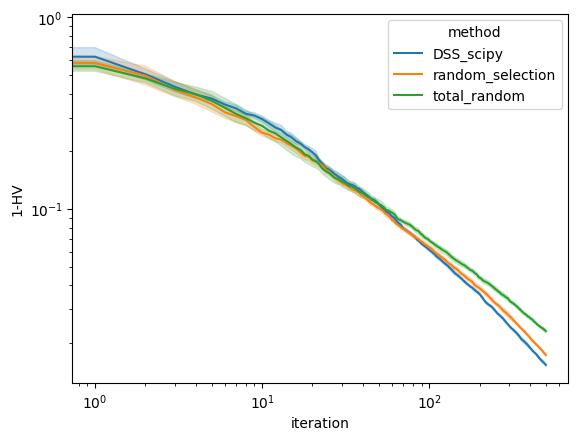

In [30]:
f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
f_pd["1-HV"] = 1 - f_pd["HV"]
sns.lineplot(data=f_pd, x="iteration", y="1-HV", hue="method")

# f.savefig(f"hv_{problem}.png")

In [5]:
rolling = pd.DataFrame(columns=["method", "runID", "iteration", "success"])

In [6]:
ids = f_pd["runID"].unique()
methods = f_pd["method"].unique()

for method in methods:
    for runID in ids:
        r = f_pd[(f_pd["method"] == method) & (f_pd["runID"] == runID)]
        rolling = pd.concat(
            [
                rolling,
                pd.DataFrame(
                    {
                        "method": [method] * len(r),
                        "runID": [runID] * len(r),
                        "iteration": r["iteration"],
                        "success": r["success"].cumsum(),
                    }
                ),
            ]
        )
rolling = rolling.dropna()

<Axes: xlabel='iteration', ylabel='success'>

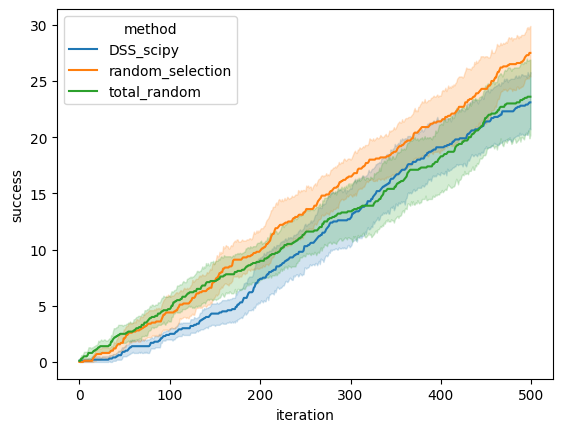

In [7]:
f, ax = plt.subplots()
sns.lineplot(data=rolling, x="iteration", y="Cumulative success", hue="method")
# f.savefig(f"success_{problem}.png")

<Axes: xlabel='iteration', ylabel='Bad Reference Points Found'>

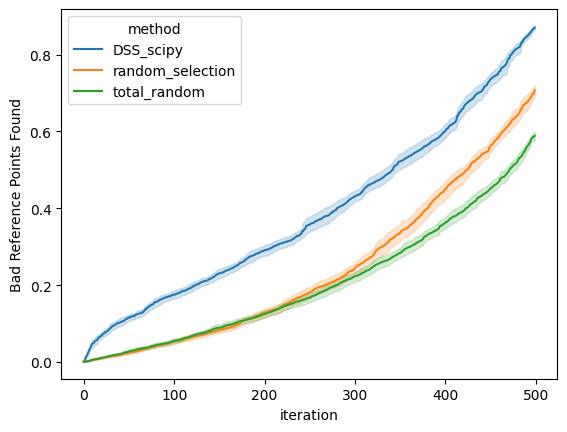

In [34]:
f, ax = plt.subplots()
sns.lineplot(data=f_pd, x="iteration", y="Bad Reference Points Found", hue="method")
# f.savefig(f"bad_ref_found_{problem}.png")